In [38]:
import os
from argparse import Namespace
from collections import Counter
import json
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm as tqdm_notebook

In [39]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
class NewsDataset(Dataset):
  def __init__(self, news_df, vectorizer):
    self.news_df = news_df
    self._vectorizer = vectorizer

    measure_len = lambda context: len(context.split())
    self._max_seq_length = max(map(measure_len, news_df.title)) + 2

    self.train_df = self.news_df[self.news_df.split=='train']
    self.train_size = len(self.train_df)

    self.val_df = self.news_df[self.news_df.split=='val']
    self.validation_size = len(self.val_df)

    self.test_df = self.news_df[self.news_df.split=='test']
    self.test_size = len(self.test_df)

    self._lookup_dict = {'train': (self.train_df, self.train_size),
                          'val': (self.val_df, self.validation_size),
                          'test': (self.test_df, self.test_size)}
    self.set_split('train')

    class_counts = news_df.category.value_counts().to_dict()
    def sort_key(item):
      return self._vectorizer.category_vocab.lookup_token(item[0])
    sorted_counts = sorted(class_counts.items(), key=sort_key)
    frequencies = [count for _, count in sorted_counts]
    self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)

  def __getitem__(self, index):
    row = self._target_df.iloc[index]

    title_vector = self._vectorizer.vectorize(row.title, self._max_seq_length)

    category_index = \
      self._vectorizer.category_vocab.lookup_token(row.category)

    return {
        "x_data": title_vector,
        "y_target": category_index
    }

  def __len__(self):
    return self._target_size

  def set_split(self, split="train"):
    self._target_split = split
    self._target_df, self._target_size = self._lookup_dict[split]

  def save_vectorizer(self, vectorizer_filepath):
    with open(vectorizer_filepath, "w") as fp:
      json.dump(self._vectorizer.to_serializable(), fp)

  def get_vectorizer(self):
    return self._vectorizer

  def get_num_batches(self, batch_size):
    return len(self) // batch_size

  @classmethod
  def load_dataset_and_make_vectorizer(cls, news_csv):
    news_df = pd.read_csv(news_csv)
    train_news_df = news_df[news_df.split=="train"]
    return cls(news_df, NewsVectorizer.from_dataframe(train_news_df))

  @classmethod
  def load_dataset_and_load_vectorizer(cls, news_csv, vectorizer_filepath):
    news_df = pd.read_csv(news_csv)
    vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
    return cls(news_df, vectorizer)

  @staticmethod
  def load_vectorizer_only(vectorizer_filepath):
    with open(vectorizer_filepath) as fp:
      return NewsVectorizer.from_serializable(json.load(fp))

def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):

  dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                          shuffle=shuffle, drop_last=drop_last)

  for data_dict in dataloader:
    out_data_dict = {}
    for name, tensor in data_dict.items():
      out_data_dict[name] = data_dict[name].to(device)
    yield out_data_dict

# Vocabulary class 개괄

## class Vocabulary(object):
### field
- _token_to_idx: token을 index로 변환하는 딕셔너리
- _idx_to_token: index를 token으로 변환하는 딕셔너리

### method

1. classmethod - decorator function
- from_serialzable: Vectorizer로 부터 vocab를 받아서 로드, 생성자 실행후 Vocabulary 인스턴스를 반환.

2. methods
- to_serializable: 딕셔너리를 통째로 반환
- add_token: token을 딕셔너리에 추가
- add_many: token들을 딕셔너리에 추가
- lookup_token: token을 index로 변환
- lookup_index: index를 token으로 변환

In [41]:
class Vocabulary():
  def __init__(self, token_to_idx=None):
    if token_to_idx is None:
      token_to_idx = {}
    self._token_to_idx = token_to_idx
    self._idx_to_token = {idx:token for token, idx in self._token_to_idx.items()}

  def to_serializable(self):
    return {"token_to_idx": self._token_to_idx}

  @classmethod
  def from_serializable(cls, contents):
    return cls(**contents)

  def add_token(self, token):
    if token in self._token_to_idx:
      index = self._token_to_idx[token]
    else:
      index = len(self._token_to_idx)
      self._token_to_idx[token] = index
      self._idx_to_token[index] = token
    return index

  def add_many(self, tokens):
    return [self.add_token(token) for token in tokens]

  def lookup_token(self,token):
    return self._token_to_idx[token]

  def lookup_index(self, index):
    if index not in self._idx_to_token:
      raise KeyError("the index (%d) is not in the Vocabulary" % index)
    return self._idx_to_token[index]

  def __str__(self):
    return "<Vocabulary(size=%d)>" % len(self)

  def __len__(self):
    return len(self._token_to_idx)

In [42]:
class SequenceVocabulary(Vocabulary): #상속
  def __init__(self, token_to_idx= None, unk_token="<UNK>",
               mask_token="<MASK>", begin_seq_token="<BEGIN>",
               end_seq_token="<END>"):
    super(SequenceVocabulary, self).__init__(token_to_idx)

    self._mask_token = mask_token
    self._unk_token = unk_token
    self._begin_seq_token = begin_seq_token
    self._end_seq_token = end_seq_token

    self.mask_index = self.add_token(self._mask_token)
    self.unk_index = self.add_token(self._unk_token)
    self.begin_seq_index = self.add_token(self._begin_seq_token)
    self.end_seq_index = self.add_token(self._end_seq_token)

  def to_serializable(self):
    contents = super(SequenceVocabulary, self).to_serializable()
    contents.update(
        {
            "unk_token": self._unk_token,
            "mask_token": self._mask_token,
            "begin_seq_token": self._begin_seq_token,
            "end_seq_token": self._end_seq_token
        }
    )
    return contents

  def lookup_token(self, token):
    if self.unk_index >= 0:
      return self._token_to_idx.get(token, self.unk_index)
    else:
      return self._token_to_idx[token]

In [43]:
class NewsVectorizer():
  def __init__(self, title_vocab, category_vocab):
    self.title_vocab = title_vocab
    self.category_vocab = category_vocab

  def vectorize(self, title, vector_length=-1):
    indices = [self.title_vocab.begin_seq_index]
    indices += [self.title_vocab.lookup_token(token) for token in title.split()]
    indices.append(self.title_vocab.end_seq_index)

    if vector_length < 0:
      vector_length = len(indices)

    out_vector = np.zeros(vector_length, dtype=np.int64)
    out_vector[:len(indices)] = indices
    out_vector[len(indices):] = self.title_vocab.mask_index

    return out_vector

  @classmethod
  def from_dataframe(cls, news_df, cutoff=25):
    category_vocab = Vocabulary()
    for category in sorted(set(news_df.category)):
      category_vocab.add_token(category)

    word_counts = Counter()
    for title in news_df.title:
      for token in title.split():
        if token not in string.punctuation:
          word_counts[token] += 1

    title_vocab = SequenceVocabulary()
    for word, word_count in word_counts.items():
      if word_count >= cutoff:
        title_vocab.add_token(word)

    return cls(title_vocab, category_vocab)

  @classmethod
  def from_serializable(cls, contents):
    # with open(vectorizer_filepath) as fp:
    # contents is... json.load(fp)
    title_vocab = \
      SequenceVocabulary.from_serializable(contents["title_vocab"])
    category_vocab = \
      Vocabulary.from_serializable(contents["category_vocab"])

    return cls(title_vocab=title_vocab, category_vocab=category_vocab)

  def to_serializable(self):
    return {
        "title_vocab": self.title_vocab.to_serializable(),
        "category_vocab": self.category_vocab.to_serializable()
    }


In [44]:
class NewsClassifier(nn.Module):
  def __init__(self, embedding_size, num_embeddings, num_channels,
               hidden_dim, num_classes, dropout_p,
               pretrained_embeddings=None, padding_idx=0):
    super(NewsClassifier, self).__init__()

    if pretrained_embeddings is None:
      self.emb = nn.Embedding(embedding_dim=embedding_size,
                              num_embeddings=num_embeddings,
                              padding_idx=padding_idx)
    else:
      pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
      self.emb = nn.Embedding(embedding_dim = embedding_size,
                              num_embeddings=num_embeddings,
                              padding_idx=padding_idx,
                              _weight=pretrained_embeddings)
    self.convnet = nn.Sequential(
        nn.Conv1d(in_channels=embedding_size,
                  out_channels=num_channels,
                  kernel_size=3), # 18
        nn.ELU(),
        nn.Conv1d(in_channels=num_channels,
                  out_channels=num_channels,
                  kernel_size=3, stride=2), # 8
        nn.ELU(),
        nn.Conv1d(in_channels=num_channels,
                  out_channels=num_channels,
                  kernel_size=3, stride=2), # 3
        nn.ELU()
    )
    self._dropout_p = dropout_p
    self.fc1 = nn.Linear(num_channels, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, num_classes)

  def forward(self, x_in, apply_softmax=False):
    # x_in.shape (batch_size, max_seq_len)
    x_embedded = self.emb(x_in) # (batch_size, max_seq_len, embedding_dim)
    x_embedded = x_embedded.permute(0, 2, 1) # (batch_size, embedding_dim, max_seq_len)
    features = self.convnet(x_embedded) # (batch_size, num_channels, kernel_output_size)

    remaining_size = features.size(dim=2)
    features = F.avg_pool1d(features, remaining_size).squeeze(dim=2) # (batch_size, num_channels)
    features = F.dropout(features, p=self._dropout_p)

    intermediate_vector = F.relu(F.dropout(self.fc1(features), p=self._dropout_p)) #(batch_size, hidden_dim)
    prediction_vector = self.fc2(intermediate_vector) #(batch_size, num_classes)
    if apply_softmax:
      prediction_vector = F.softmax(prediction_vector, dim=1)

    return prediction_vector

In [45]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """훈련 상태를 업데이트합니다.

    Components:
     - 조기 종료: 과대 적합 방지
     - 모델 체크포인트: 더 나은 모델을 저장합니다

    :param args: 메인 매개변수
    :param model: 훈련할 모델
    :param train_state: 훈련 상태를 담은 딕셔너리
    :returns:
        새로운 훈련 상태
    """

    # 적어도 한 번 모델을 저장합니다
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # 성능이 향상되면 모델을 저장합니다
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # 손실이 나빠지면
        if loss_t >= train_state['early_stopping_best_val']:
            # 조기 종료 단계 업데이트
            train_state['early_stopping_step'] += 1
        # 손실이 감소하면
        else:
            # 최상의 모델 저장
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # 조기 종료 단계 재설정
            train_state['early_stopping_step'] = 0

        # 조기 종료 여부 확인
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [46]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

def load_glove_from_file(glove_filepath):
    """GloVe 임베딩 로드

    매개변수:
        glove_filepath (str): 임베딩 파일 경로
    반환값:
        word_to_index (dict), embeddings (numpy.ndarary)
    """

    word_to_index = {}
    embeddings = []
    with open(glove_filepath, "r") as fp:
        for index, line in enumerate(fp):
            line = line.split(" ") # each line: word num1 num2 ...
            word_to_index[line[0]] = index # word = line[0]
            embedding_i = np.array([float(val) for val in line[1:]])
            embeddings.append(embedding_i)
    return word_to_index, np.stack(embeddings)

def make_embedding_matrix(glove_filepath, words):
    """
    특정 단어 집합에 대한 임베딩 행렬을 만듭니다.

    매개변수:
        glove_filepath (str): 임베딩 파일 경로
        words (list): 단어 리스트
    """
    word_to_idx, glove_embeddings = load_glove_from_file(glove_filepath)
    embedding_size = glove_embeddings.shape[1]

    final_embeddings = np.zeros((len(words), embedding_size))

    for i, word in enumerate(words):
        if word in word_to_idx:
            final_embeddings[i, :] = glove_embeddings[word_to_idx[word]]
        else:
            embedding_i = torch.ones(1, embedding_size)
            torch.nn.init.xavier_uniform_(embedding_i)
            final_embeddings[i, :] = embedding_i

    return final_embeddings

In [47]:
from argparse import Namespace

In [48]:
base_path="/content/drive/MyDrive/Github_NLP/NLP_with_PyTorch/Chapter5_Words_And_TypeEmbedding/"
args = Namespace(
    # 날짜와 경로 정보
    news_csv=base_path + "data/ag_news/news_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir=base_path + "model_storage/ch5/document_classification",
    # 모델 하이퍼파라미터
    glove_filepath=base_path + 'glove100d/glove.6B.100d.txt',
    use_glove=False,
    embedding_size=100,
    hidden_dim=100,
    num_channels=100,
    # 훈련 하이퍼파라미터
    seed=1337,
    learning_rate=0.001,
    dropout_p=0.1,
    batch_size=128,
    num_epochs=100,
    early_stopping_criteria=5,
    # 실행 옵션
    cuda=True,
    catch_keyboard_interrupt=True,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)

    print("파일 경로: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))

#기본경로 체크
print("기본경로")
print(args.news_csv)
print(args.save_dir)
print(args.glove_filepath)

# CUDA 체크
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
print("CUDA 사용여부: {}".format(args.cuda))

# 재현성을 위해 시드 설정
set_seed_everywhere(args.seed, args.cuda)

# 디렉토리 처리
handle_dirs(args.save_dir)

파일 경로: 
	/content/drive/MyDrive/Github_NLP/NLP_with_PyTorch/Chapter5_Words_And_TypeEmbedding/model_storage/ch5/document_classification/vectorizer.json
	/content/drive/MyDrive/Github_NLP/NLP_with_PyTorch/Chapter5_Words_And_TypeEmbedding/model_storage/ch5/document_classification/model.pth
기본경로
/content/drive/MyDrive/Github_NLP/NLP_with_PyTorch/Chapter5_Words_And_TypeEmbedding/data/ag_news/news_with_splits.csv
/content/drive/MyDrive/Github_NLP/NLP_with_PyTorch/Chapter5_Words_And_TypeEmbedding/model_storage/ch5/document_classification
/content/drive/MyDrive/Github_NLP/NLP_with_PyTorch/Chapter5_Words_And_TypeEmbedding/glove100d/glove.6B.100d.txt
CUDA 사용여부: True


In [49]:
#GLOVE 사용여부
args.use_glove = True

In [50]:
if args.reload_from_files:
    # 체크포인트를 로드합니다.
    dataset = NewsDataset.load_dataset_and_load_vectorizer(args.news_csv,
                                                              args.vectorizer_file)
else:
    # 데이터셋과 Vectorizer를 만듭니다.
    dataset = NewsDataset.load_dataset_and_make_vectorizer(args.news_csv)
    dataset.save_vectorizer(args.vectorizer_file)
vectorizer = dataset.get_vectorizer()

# GloVe를 사용하거나 랜덤하게 임베딩을 초기화합니다
if args.use_glove:
    words = vectorizer.title_vocab._token_to_idx.keys()
    embeddings = make_embedding_matrix(glove_filepath=args.glove_filepath,
                                       words=words)
    print("사전 훈련된 임베딩을 사용합니다")
else:
    print("사전 훈련된 임베딩을 사용하지 않습니다")
    embeddings = None

classifier = NewsClassifier(embedding_size=args.embedding_size,
                            num_embeddings=len(vectorizer.title_vocab),
                            num_channels=args.num_channels,
                            hidden_dim=args.hidden_dim,
                            num_classes=len(vectorizer.category_vocab),
                            dropout_p=args.dropout_p,
                            pretrained_embeddings=embeddings,
                            padding_idx=0)

사전 훈련된 임베딩을 사용합니다


In [51]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)

loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = make_train_state(args)

epoch_bar = tqdm_notebook(desc='training routine',
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm_notebook(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size),
                          position=1,
                          leave=True)
dataset.set_split('val')
val_bar = tqdm_notebook(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size),
                        position=1,
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # 훈련 세트에 대한 순회

        # 훈련 세트와 배치 제너레이터 준비, 손실과 정확도를 0으로 설정
        dataset.set_split('train')
        batch_generator = generate_batches(dataset,
                                           batch_size=args.batch_size,
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # 훈련 과정은 5단계로 이루어집니다

            # --------------------------------------
            # 단계 1. 그레이디언트를 0으로 초기화합니다
            optimizer.zero_grad()

            # 단계 2. 출력을 계산합니다
            y_pred = classifier(batch_dict['x_data'])

            # 단계 3. 손실을 계산합니다
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # 단계 4. 손실을 사용해 그레이디언트를 계산합니다
            loss.backward()

            # 단계 5. 옵티마이저로 가중치를 업데이트합니다
            optimizer.step()
            # -----------------------------------------

            # 정확도를 계산합니다
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # 진행 상태 막대 업데이트
            train_bar.set_postfix(loss=running_loss, acc=running_acc,
                                  epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # 검증 세트에 대한 순회

        # 검증 세트와 배치 제너레이터 준비, 손실과 정확도를 0으로 설정
        dataset.set_split('val')
        batch_generator = generate_batches(dataset,
                                           batch_size=args.batch_size,
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # 단계 1. 출력을 계산합니다
            y_pred =  classifier(batch_dict['x_data'])

            # 단계 2. 손실을 계산합니다
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # 단계 3. 정확도를 계산합니다
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc,
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")

# google.colab V100 GPU
# epoch:7
# duration of time: 1분 50초

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/656 [00:00<?, ?it/s]

split=val:   0%|          | 0/140 [00:00<?, ?it/s]

In [52]:
# 가장 좋은 모델을 사용해 테스트 세트의 손실과 정확도를 계산합니다
classifier.load_state_dict(torch.load(train_state['model_filename']))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset,
                                   batch_size=args.batch_size,
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # 출력을 계산합니다
    y_pred =  classifier(batch_dict['x_data'])

    # 손실을 계산합니다
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # 정확도를 계산합니다
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [53]:
print("테스트 손실: {};".format(train_state['test_loss']))
print("테스트 정확도: {}".format(train_state['test_acc']))

테스트 손실: 0.4480202751500267;
테스트 정확도: 83.94531250000004


In [54]:
# 리뷰 텍스트를 전처리합니다
def preprocess_text(text):
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text

In [55]:
def predict_category(title, classifier, vectorizer, max_length):
    """뉴스 제목을 기반으로 카테고리를 예측합니다

    매개변수:
        title (str): 원시 제목 문자열
        classifier (NewsClassifier): 훈련된 분류기 객체
        vectorizer (NewsVectorizer): 해당 Vectorizer
        max_length (int): 최대 시퀀스 길이
            노트: CNN은 입력 텐서 크기에 민감합니다.
                 훈련 데이터처럼 동일한 크기를 갖도록 만듭니다.
    """
    title = preprocess_text(title)
    vectorized_title = \
        torch.tensor(vectorizer.vectorize(title, vector_length=max_length))
    result = classifier(vectorized_title.unsqueeze(0), apply_softmax=True)
    probability_values, indices = result.max(dim=1)
    predicted_category = vectorizer.category_vocab.lookup_index(indices.item())

    return {'category': predicted_category,
            'probability': probability_values.item()}

In [56]:
def get_samples():
    samples = {}
    for cat in dataset.val_df.category.unique():
        samples[cat] = dataset.val_df.title[dataset.val_df.category==cat].tolist()[:5]
    return samples

val_samples = get_samples()

In [57]:
#title = input("Enter a news title to classify: ")
classifier = classifier.to("cpu")

for truth, sample_group in val_samples.items():
    print(f"True Category: {truth}")
    print("="*30)
    for sample in sample_group:
        prediction = predict_category(sample, classifier,
                                      vectorizer, dataset._max_seq_length + 1)
        print("예측: {} (p={:0.2f})".format(prediction['category'],
                                                  prediction['probability']))
        print("\t + 샘플: {}".format(sample))
    print("-"*30 + "\n")

True Category: Business
예측: Business (p=0.78)
	 + 샘플: az suspends marketing of cancer drug
예측: Business (p=0.86)
	 + 샘플: business world has mixed reaction to perez move
예측: Sports (p=0.64)
	 + 샘플: betting against bombay
예측: Business (p=0.86)
	 + 샘플: malpractice insurers face a tough market
예측: Sci/Tech (p=0.59)
	 + 샘플: nvidia is vindicated
------------------------------

True Category: Sci/Tech
예측: World (p=0.47)
	 + 샘플: spies prize webcam s eyes
예측: Sci/Tech (p=0.96)
	 + 샘플: sober worm causes headaches
예측: Sci/Tech (p=0.71)
	 + 샘플: local search missing pieces falling into place
예측: Sci/Tech (p=0.99)
	 + 샘플: hackers baiting internet users with beckham pix
예측: Sci/Tech (p=0.88)
	 + 샘플: nokia adds blackberry support to series handsets
------------------------------

True Category: Sports
예측: Sports (p=0.86)
	 + 샘플: is meyer the man to get irish up ? 
예측: Sports (p=0.86)
	 + 샘플: who ? who ? and clemens
예측: Sports (p=0.95)
	 + 샘플: baseball today ap 
예측: Sports (p=0.83)
	 + 샘플: mark kreidle

In [37]:
#custom predictions
for i in range(len(vectorizer.category_vocab)):
  print(vectorizer.category_vocab.lookup_index(i), end=", ")
print()
num_samples = int(input("Enter the number of news: "))
samples_dict={}
for i in range(num_samples):
  title = input("Enter a news title to classify: ")
  truth = input("Enter the ground-truth of the news: ")
  samples_dict[truth] = title


classifier = classifier.to("cpu")

for truth, sample in samples_dict.items():
    print(f"True Category: {truth}")
    print("="*30)
    prediction = predict_category(sample, classifier,
                                  vectorizer, dataset._max_seq_length + 1)
    print("예측: {} (p={:0.2f})".format(prediction['category'],
                                              prediction['probability']))
    print("\t + 샘플: {}".format(sample))
    print("-"*30 + "\n")

Business, Sci/Tech, Sports, World, Enter the number of news: 1
Enter a news title to classify: ICC, WTO heads urge business dialogue to inform response to trade fallout from COVID-19
Enter the ground-truth of the news: Business
True Category: Business
예측: Business (p=0.96)
	 + 샘플: ICC, WTO heads urge business dialogue to inform response to trade fallout from COVID-19
------------------------------



# Without Pretrained Embedding

In [58]:
base_path="/content/drive/MyDrive/Github_NLP/NLP_with_PyTorch/Chapter5_Words_And_TypeEmbedding/"
args_without_pretrained_embedded = Namespace(
    # 날짜와 경로 정보
    news_csv=base_path + "data/ag_news/news_with_splits.csv",
    vectorizer_file="vectorizer_without_glove.json",
    model_state_file="model_without_glove.pth",
    save_dir=base_path + "model_storage/ch5/document_classification",
    # 모델 하이퍼파라미터
    glove_filepath=base_path + 'glove100d/glove.6B.100d.txt',
    use_glove=False,
    embedding_size=100,
    hidden_dim=100,
    num_channels=100,
    # 훈련 하이퍼파라미터
    seed=1337,
    learning_rate=0.001,
    dropout_p=0.1,
    batch_size=128,
    num_epochs=100,
    early_stopping_criteria=5,
    # 실행 옵션
    cuda=True,
    catch_keyboard_interrupt=True,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True
)

if args_without_pretrained_embedded.expand_filepaths_to_save_dir:
    args_without_pretrained_embedded.vectorizer_file = os.path.join(args_without_pretrained_embedded.save_dir,
                                        args_without_pretrained_embedded.vectorizer_file)

    args_without_pretrained_embedded.model_state_file = os.path.join(args_without_pretrained_embedded.save_dir,
                                         args_without_pretrained_embedded.model_state_file)

    print("파일 경로: ")
    print("\t{}".format(args_without_pretrained_embedded.vectorizer_file))
    print("\t{}".format(args_without_pretrained_embedded.model_state_file))

#기본경로 체크
print("기본경로")
print(args_without_pretrained_embedded.news_csv)
print(args_without_pretrained_embedded.save_dir)
print(args_without_pretrained_embedded.glove_filepath)

# CUDA 체크
if not torch.cuda.is_available():
    args_without_pretrained_embedded.cuda = False

args_without_pretrained_embedded.device = torch.device("cuda" if args_without_pretrained_embedded.cuda else "cpu")
print("CUDA 사용여부: {}".format(args_without_pretrained_embedded.cuda))

# 재현성을 위해 시드 설정
set_seed_everywhere(args_without_pretrained_embedded.seed, args_without_pretrained_embedded.cuda)

# 디렉토리 처리
handle_dirs(args_without_pretrained_embedded.save_dir)

파일 경로: 
	/content/drive/MyDrive/Github_NLP/NLP_with_PyTorch/Chapter5_Words_And_TypeEmbedding/model_storage/ch5/document_classification/vectorizer_without_glove.json
	/content/drive/MyDrive/Github_NLP/NLP_with_PyTorch/Chapter5_Words_And_TypeEmbedding/model_storage/ch5/document_classification/model_without_glove.pth
기본경로
/content/drive/MyDrive/Github_NLP/NLP_with_PyTorch/Chapter5_Words_And_TypeEmbedding/data/ag_news/news_with_splits.csv
/content/drive/MyDrive/Github_NLP/NLP_with_PyTorch/Chapter5_Words_And_TypeEmbedding/model_storage/ch5/document_classification
/content/drive/MyDrive/Github_NLP/NLP_with_PyTorch/Chapter5_Words_And_TypeEmbedding/glove100d/glove.6B.100d.txt
CUDA 사용여부: True


In [61]:
if args_without_pretrained_embedded.reload_from_files:
    # 체크포인트를 로드합니다.
    dataset_no_emb = NewsDataset.load_dataset_and_load_vectorizer(args_without_pretrained_embedded.news_csv,
                                                              args_without_pretrained_embedded.vectorizer_file)
else:
    # 데이터셋과 Vectorizer를 만듭니다.
    dataset_no_emb = NewsDataset.load_dataset_and_make_vectorizer(args_without_pretrained_embedded.news_csv)
    dataset_no_emb.save_vectorizer(args_without_pretrained_embedded.vectorizer_file)
vectorizer_no_emb = dataset_no_emb.get_vectorizer()


print("사전 훈련된 임베딩을 사용하지 않습니다")
embeddings = None

classifier_without_embedded = NewsClassifier(embedding_size=args_without_pretrained_embedded.embedding_size,
                            num_embeddings=len(vectorizer_no_emb.title_vocab),
                            num_channels=args_without_pretrained_embedded.num_channels,
                            hidden_dim=args_without_pretrained_embedded.hidden_dim,
                            num_classes=len(vectorizer_no_emb.category_vocab),
                            dropout_p=args_without_pretrained_embedded.dropout_p,
                            pretrained_embeddings=embeddings,
                            padding_idx=0)

사전 훈련된 임베딩을 사용하지 않습니다


In [62]:
classifier_without_embedded = classifier_without_embedded.to(args.device)
dataset_no_emb.class_weights = dataset_no_emb.class_weights.to(args_without_pretrained_embedded.device)

loss_func = nn.CrossEntropyLoss(dataset_no_emb.class_weights)
optimizer = optim.Adam(classifier_without_embedded.parameters(), lr=args_without_pretrained_embedded.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state_no_emb = make_train_state(args_without_pretrained_embedded)

epoch_bar = tqdm_notebook(desc='training routine',
                          total=args_without_pretrained_embedded.num_epochs,
                          position=0)

dataset_no_emb.set_split('train')
train_bar = tqdm_notebook(desc='split=train',
                          total=dataset_no_emb.get_num_batches(args_without_pretrained_embedded.batch_size),
                          position=1,
                          leave=True)
dataset_no_emb.set_split('val')
val_bar = tqdm_notebook(desc='split=val',
                        total=dataset_no_emb.get_num_batches(args_without_pretrained_embedded.batch_size),
                        position=1,
                        leave=True)

try:
    for epoch_index in range(args_without_pretrained_embedded.num_epochs):
        train_state_no_emb['epoch_index'] = epoch_index

        # 훈련 세트에 대한 순회

        # 훈련 세트와 배치 제너레이터 준비, 손실과 정확도를 0으로 설정
        dataset_no_emb.set_split('train')
        batch_generator = generate_batches(dataset_no_emb,
                                           batch_size=args_without_pretrained_embedded.batch_size,
                                           device=args_without_pretrained_embedded.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier_without_embedded.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # 훈련 과정은 5단계로 이루어집니다

            # --------------------------------------
            # 단계 1. 그레이디언트를 0으로 초기화합니다
            optimizer.zero_grad()

            # 단계 2. 출력을 계산합니다
            y_pred = classifier_without_embedded(batch_dict['x_data'])

            # 단계 3. 손실을 계산합니다
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # 단계 4. 손실을 사용해 그레이디언트를 계산합니다
            loss.backward()

            # 단계 5. 옵티마이저로 가중치를 업데이트합니다
            optimizer.step()
            # -----------------------------------------

            # 정확도를 계산합니다
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # 진행 상태 막대 업데이트
            train_bar.set_postfix(loss=running_loss, acc=running_acc,
                                  epoch=epoch_index)
            train_bar.update()

        train_state_no_emb['train_loss'].append(running_loss)
        train_state_no_emb['train_acc'].append(running_acc)

        # 검증 세트에 대한 순회

        # 검증 세트와 배치 제너레이터 준비, 손실과 정확도를 0으로 설정
        dataset_no_emb.set_split('val')
        batch_generator = generate_batches(dataset_no_emb,
                                           batch_size=args_without_pretrained_embedded.batch_size,
                                           device=args_without_pretrained_embedded.device)
        running_loss = 0.
        running_acc = 0.
        classifier_without_embedded.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # 단계 1. 출력을 계산합니다
            y_pred =  classifier_without_embedded(batch_dict['x_data'])

            # 단계 2. 손실을 계산합니다
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # 단계 3. 정확도를 계산합니다
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc,
                            epoch=epoch_index)
            val_bar.update()

        train_state_no_emb['val_loss'].append(running_loss)
        train_state_no_emb['val_acc'].append(running_acc)

        train_state_no_emb = update_train_state(args=args_without_pretrained_embedded, model=classifier_without_embedded,
                                         train_state=train_state_no_emb)

        scheduler.step(train_state_no_emb['val_loss'][-1])

        if train_state_no_emb['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")

# google.colab V100 GPU
# epoch:10
# duration of time: 2분 45초

training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/656 [00:00<?, ?it/s]

split=val:   0%|          | 0/140 [00:00<?, ?it/s]

In [24]:
import matplotlib.pyplot as plt

def plot(targets, labels=None,  figsize=None, xlabel=None, ylabel=None, grid=False, ylim=[], title=None, legend=False):
  if figsize != None:
    plt.figure(figsize=figsize)

  if labels == None:
    labels = [None] * len(targets)
  for i, target in enumerate(targets):
    target = np.array(target)
    x = np.arange(len(target))
    plt.plot(x, target, label=labels[i])
  if len(ylim) != 0:
    plt.ylim(ylim[0], ylim[1])
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.grid(grid)
  if legend:
    plt.legend()


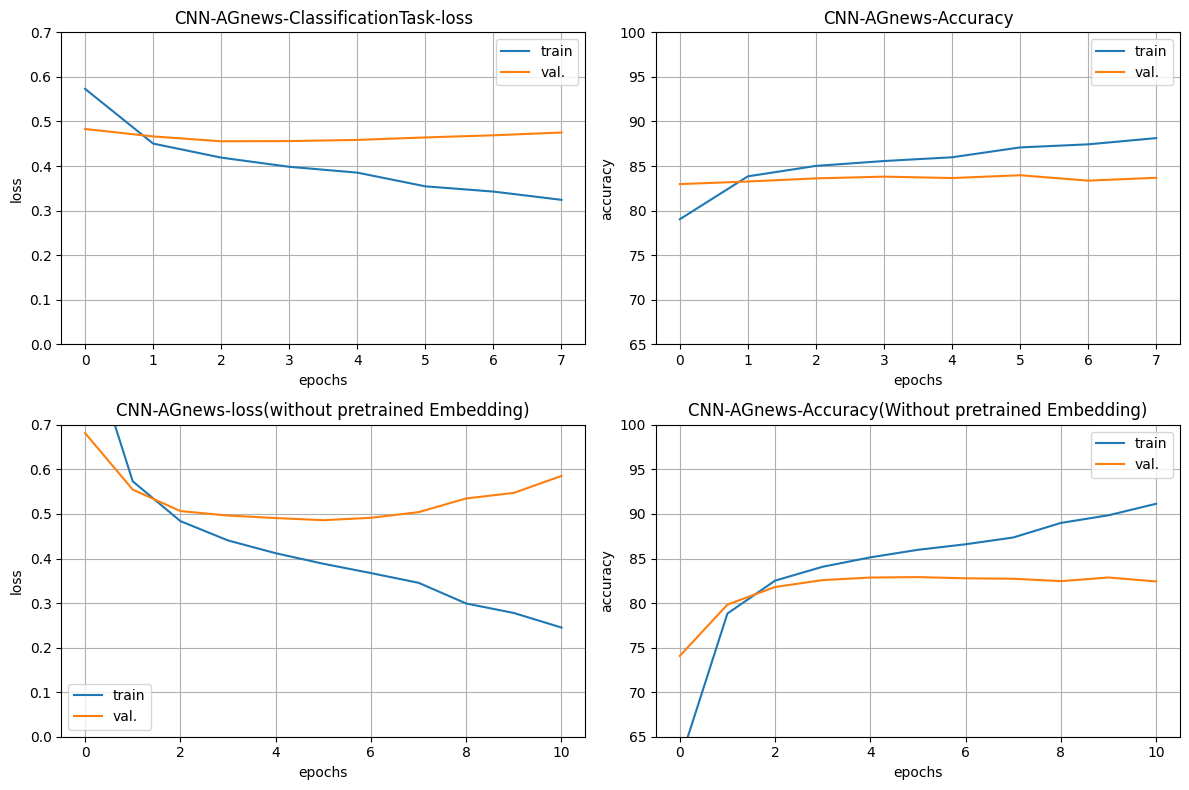

In [68]:
plt.figure(figsize=(12, 8))
plt.subplot(221)
plot(
    targets=(train_state["train_loss"], train_state["val_loss"]),
    labels = ["train", "val."],
    xlabel = "epochs",
    ylabel = "loss",
    ylim =[0, .7],
    grid = True,
    title = "CNN-AGnews-ClassificationTask-loss",
    legend=True
    )
plt.subplot(222)
plot(
    targets=(train_state["train_acc"], train_state["val_acc"]),
    labels = ["train", "val."],
    xlabel = "epochs",
    ylabel = "accuracy",
    grid = True,
    ylim=[65,100],
    title = "CNN-AGnews-Accuracy",
    legend=True
    )
plt.subplot(223)
plot(
    targets=(train_state_no_emb["train_loss"], train_state_no_emb["val_loss"]),
    labels = ["train", "val."],
    xlabel = "epochs",
    ylabel = "loss",
    ylim =[0, .7],
    grid = True,
    title = "CNN-AGnews-loss(without pretrained Embedding)",
    legend=True
    )
plt.subplot(224)
plot(
    targets=(train_state_no_emb["train_acc"], train_state_no_emb["val_acc"]),
    labels = ["train", "val."],
    xlabel = "epochs",
    ylabel = "accuracy",
    ylim=[65, 100],
    grid = True,
    title = "CNN-AGnews-Accuracy(Without pretrained Embedding)",
    legend=True
    )
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

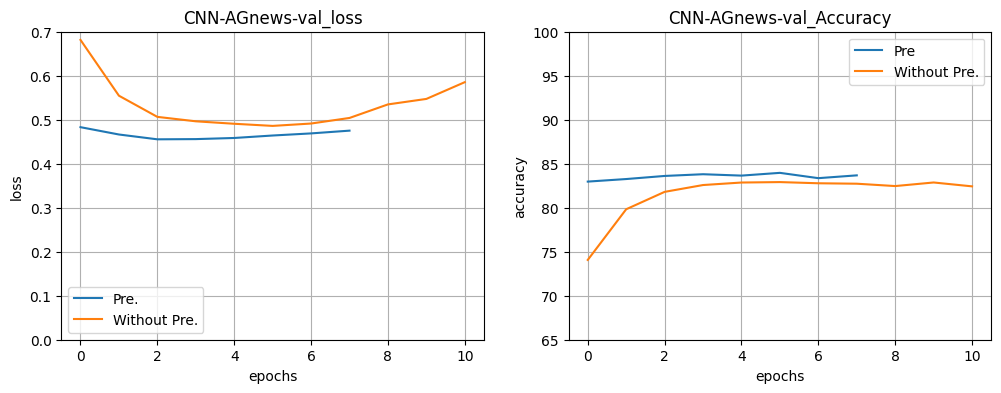

In [70]:
plt.clf()
plt.figure(figsize=(12, 4))
plt.subplot(121)
plot(
    targets=(train_state["val_loss"], train_state_no_emb["val_loss"]),
    labels = ["Pre.", "Without Pre."],
    xlabel = "epochs",
    ylabel = "loss",
    ylim =[0, .7],
    grid = True,
    title = "CNN-AGnews-val_loss",
    legend=True
    )
plt.subplot(122)
plot(
    targets=(train_state["val_acc"], train_state_no_emb["val_acc"]),
    labels = ["Pre", "Without Pre."],
    xlabel = "epochs",
    ylabel = "accuracy",
    grid = True,
    ylim=[65,100],
    title = "CNN-AGnews-val_Accuracy",
    legend=True
    )


In [76]:
subtraction = train_state["val_acc"][-1] - train_state_no_emb["val_acc"][-1]
epoch_subtraction = -(len(train_state["val_acc"]) - len(train_state_no_emb["val_acc"]))
print("pretrained embedding 을 쓰지 않은 모델의 정확도가 %.2f 떨어짐." % subtraction)
print("pretrained embedding 을 쓰지 않은 모델의 에폭이 %d 에폭 더 많음." % epoch_subtraction)

#걸린시간
#without_pretrained_embedding : 2분 45초
#with glove100d: 1분 50초

pretrained embedding 을 쓰지 않은 모델의 정확도가 1.25 떨어짐.
pretrained embedding 을 쓰지 않은 모델의 에폭이 3 에폭 더 많음.


In [21]:
def describe(x):
  print(x.type())
  print(x.shape)
  print(x)

In [22]:
"""
#Classifier 차원 확인

batch_size = 128
max_seq_len = 20
x_in = np.random.randint(size=(batch_size, max_seq_len), low=0, high=1000)
max_num = int(np.max(x_in))
x_in = torch.from_numpy(x_in)


model = NewsClassifier(
    embedding_size = 100,
    num_embeddings = 1000,
    num_channels=10,
    hidden_dim = 50,
    num_classes= 10,
    dropout_p = 0.5,
    pretrained_embeddings=None,
    padding_idx=0
)

y_pred = model.forward(x_in)
describe(y_pred)
"""

'\n#Classifier 차원 확인\n\nbatch_size = 128\nmax_seq_len = 20\nx_in = np.random.randint(size=(batch_size, max_seq_len), low=0, high=1000)\nmax_num = int(np.max(x_in))\nx_in = torch.from_numpy(x_in)\n\n\nmodel = NewsClassifier(\n    embedding_size = 100,\n    num_embeddings = 1000,\n    num_channels=10,\n    hidden_dim = 50,\n    num_classes= 10,\n    dropout_p = 0.5,\n    pretrained_embeddings=None,\n    padding_idx=0\n)\n\ny_pred = model.forward(x_in)\ndescribe(y_pred)\n'